In [1]:
# URL Download
import csv
import io
import urllib.request
import requests

import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt

In [2]:
# Read in data from the Berlin Polizei URL
def load_data():
    url = "https://www.internetwache-polizei-berlin.de/vdb/Fahrraddiebstahl.csv"
    download = requests.get(url)
    decoded_content = download.content.decode('ISO-8859-1')
    file = decoded_content.splitlines()

    cr = csv.DictReader(file, delimiter=',')
    my_list = list(cr)
    df  = pd.DataFrame(my_list)
    return df

In [3]:
###################################
###  Clean data ######

#dict to translate from German to English
eng_col_names = {
    "ANGELEGT_AM": "date_reported",
    "TATZEIT_ANFANG_DATUM": "date_theft_start",
    "TATZEIT_ANFANG_STUNDE": "hour_theft_start",
    "TATZEIT_ENDE_DATUM": "date_theft_end",
    "TATZEIT_ENDE_STUNDE": "hour_theft_end",
    "LOR": "LOR",
    "SCHADENSHOEHE": "estimated_value",
    "VERSUCH": "attempt",
    "ART_DES_FAHRRADS": "type_bike", 
    "DELIKT": "theft_type",
    "ERFASSUNGSGRUND": "theft_type_detail"    
}

# define function for renaming the categories
def rename_type_bike(x): 
    if x == "Herrenfahrrad": 
        return "man's bike"
    if x == "Damenfahrrad":
        return "woman's bike"
    if x == "Fahrrad":
        return "bike"
    if x == "Kinderfahrrad":
        return "child's bike"
    else: 
        return "other bike"

# dictionary for "attempt"
attempt_dict = {
    "Ja": "Yes", 
    "Nein": "No", 
    "Unbekannt": "Unknown"
}

In [4]:
# Concatenates translation of column and category names, 
#  conversion of dtypes, drop duplicates and create 
#  higher regional levels from LOR
def clean_theft_data(d):
    """returns a clean dataframe"""
    #translate columns to English
    d.rename(columns= eng_col_names, inplace=True)
    
    #translate bike type to English
    d["type_bike"] = d["type_bike"].apply(rename_type_bike)
    
    #translate attempt type to English
    d["attempt"] = d["attempt"].map(attempt_dict)
    
    # convert the date columns to format='%d.%m.%Y
    d["date_reported"] = pd.to_datetime(d["date_reported"], format='%d.%m.%Y')
    d["date_theft_start"] = pd.to_datetime(d["date_theft_start"], format='%d.%m.%Y')
    d["date_theft_end"] = pd.to_datetime(d["date_theft_end"], format='%d.%m.%Y')
    
    # convert the time columns to int
    d["hour_theft_start"] = d["hour_theft_start"].astype(int)
    d["hour_theft_end"] = d["hour_theft_end"].astype(int)
    
    #convert value column to float
    d["estimated_value"] = d["estimated_value"].astype(float)
    
    #drop duplicates
    d = d.drop_duplicates()
    
    # BZR (first six numbers)
    d["BZR"] = d["LOR"].str[:6]
    
    # PGR (first four numbers)
    d["PGR"] = d["LOR"].str[:4]
    
    # Bezirk (first four numbers)
    d["Bezirk"] = d["LOR"].str[:2]
    
    return d

In [5]:
# Group by bezirk and date reported sum up
def pivot_theft_data(d):
    d = d.pivot_table(index = "date_reported", columns = "Bezirk", values = "type_bike", aggfunc= "count")
    d.fillna(value = 0, inplace=True)
    return d

In [6]:
# Calculate percentage theft by Bezirk
def perc_split_bezirk(d):
    """returns df showing % split of bikes stolen over the last 2 weeks per Bezirk in Berlin"""
    d = d[-15:]
    d.loc['perc_split']= d.sum()
    d = d.div(d.sum(axis=1), axis=0)
    d = d.iloc[-1]
    return pd.DataFrame(d)

In [7]:
def calculate_rolling_average(df, window_size):
    fill_value = df["total"][-window_size:].mean()
    df["total_moving_average"] = df["total"].rolling(window = window_size, center = False).mean().fillna(fill_value)

In [8]:
# Create the dataframe for the modelling
def create_modelling_dataframe():
    df = load_data()
    df = clean_theft_data(df)
    df = pivot_theft_data(df)

    # add "total column"
    df["total"] = df.sum(axis = 1)

    # calculate rolling average
    calculate_rolling_average(df, window_size = 3)
    
    # select relevant columns for modelling
    cols_list =  ["total", "total_moving_average"]
    df = df[cols_list]
    
    return df

In [9]:
def bikes_stolen_365():
    """returns total bikes stolen in the last 365 days in Berlin"""
    df = load_data()
    df = clean_theft_data(df)
    df = pivot_theft_data(df)
    df['Total'] = df.sum(axis=1)
    df = pd.DataFrame(df["Total"])
    df =df[-365:]
    total_stolen_365=df.sum().values[0]
    return int(total_stolen_365)

In [10]:
def theft_frequency():
    """returns frequency (in minutes) of bikes stolen in Berlin in the last 365 days"""
    minutes_day=1440
    minutes_year=1440*365
    return round(minutes_year/bikes_stolen_365())

In [11]:
def get_X_y(dataset, window_size= 31, future_horizon =1):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size])
    y.append(dataset["total"][i + window_size: i + window_size + future_horizon])

  return np.array(X), np.array(y)

In [12]:
import numpy as np
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential, callbacks

def create_opt_model(): 
    """
    Creates the finetuned model selected in B_Theft_Modelling
    Outputs models, that needs to be compiled and fit"""
    model = Sequential()
    # first LSTM layer
    model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
    model.add(Dropout(0.2))
    # second LSTM layer
    model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
    model.add(Dropout(0.2))

    # output layer to predict one value
    model.add(Dense(1, activation= "linear"))
    return model

2022-03-16 19:14:10.022602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 19:14:10.022680: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
def get_pred_array():
    # read in dataset from URL
    df = load_data()
    # clean dataset
    clean_theft_data(df)
    # group by Bezirk and date reported
    pivot_theft_data(df)
    # add "total column"
    df["total"] = df.sum(axis = 1)
    # calculate rolling average
    calculate_rolling_average(df, window_size = 3)
    # drop not-needed columns
    cols_list =  ["total", "total_moving_average"]
    df = df[cols_list]
    # only keep last 31 days

In [14]:
from json import load
from webbrowser import get
import joblib
import numpy as np
import pandas as pd
import datetime
import plotly.express as px
from apps.theft_data import *

import warnings
warnings.filterwarnings("ignore")


# load model from joblib file
def load_joblib_model():
    """Read in the fitted model from the locally saved joblib.file
    """
    model = joblib.load("../data/model.joblib")
    return model


# read in X_array for prediction
def get_pred_array():
    """"Create the input array X to predict for the next day
    """
    # read in newest dataset from the URL
    df = create_modelling_dataframe()
    # only keep last 31 days
    df = df[-31:]
    #create input array
    X_input = np.expand_dims(df, axis = 0)
    pred_date =  df.index[-1] +  datetime.timedelta(days = 1)

    return X_input, pred_date.date()

def predict_next_day():
    """Given an input array X of shape (1, 31, 2) predict a total value
    for the next day.
    Output: Predicted value and date the prediction refers to"""
    X_input, pred_date = get_pred_array()

    # load model and predict
    model = load_joblib_model()
    y_pred = model.predict(X_input)
    d = {"date_reported": pred_date,
         "total": round(y_pred[0][0], 0)}
    return pd.DataFrame(d, index = [0])



def prediction_by_Bezirk():
    """Allocates the predicted total for the next day on the 12 Bezirke
    based on the mean percentage split for the last 14 days.
    """
    # load data, clean it and group by Bezirke
    df = load_data()
    df= clean_theft_data(df)
    df = pivot_theft_data(df)

    # create dataframe with the mean percentage split of the last 14 days
    df= perc_split_bezirk(df)

    # call the prediction for the next day and assign it as a new column to the dataframe
    df["pred_total"] = predict_next_day().iloc[0,1]

    # create dataframe with just the split up values
    df  = pd.DataFrame(round(df["perc_split"] * df["pred_total"], 0)).rename(columns={0: "Prediction_total"})

    return df

# Model fit graph

In [44]:
df = create_modelling_dataframe()

In [45]:
df

Bezirk,total,total_moving_average
date_reported,,
2021-01-01,4.0,54.000000
2021-01-02,7.0,54.000000
2021-01-03,3.0,4.666667
2021-01-04,21.0,10.333333
2021-01-05,31.0,18.333333
...,...,...
2022-03-11,53.0,59.333333
2022-03-12,40.0,50.666667
2022-03-13,42.0,45.000000


In [46]:
df.to_csv("../data/bike_theft_cleaned.csv")

In [17]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_train)
X_test, y_test = get_X_y(window_size, future_horizon, df_test)

X_test = np.expand_dims(X_test, 2)
X_train = np.expand_dims(X_train, 2)

NameError: name 'df_train' is not defined

In [19]:
model = create_opt_model()

2022-03-10 15:18:02.266852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-10 15:18:02.266965: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-10 15:18:02.267021: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-C0GM00LC): /proc/driver/nvidia/version does not exist
2022-03-10 15:18:02.268112: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Predict on the last 31 days

In [18]:
pred_df = df[-31:]

In [19]:
pred_df.head()

Bezirk,total,total_moving_average
date_reported,,
2022-02-13,50.0,48.333333
2022-02-14,53.0,48.000000
2022-02-15,53.0,52.000000
2022-02-16,48.0,51.333333
2022-02-17,47.0,49.333333


In [20]:
# Load static model from joblib file
model = joblib.load("../data/model.joblib")

2022-03-16 19:14:44.243496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 19:14:44.243529: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 19:14:44.243551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-C0GM00LC): /proc/driver/nvidia/version does not exist
2022-03-16 19:14:44.244416: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
df = df[-31 - 31:] 

In [22]:
X, y = get_X_y(df)

In [23]:
X.shape, y.shape

((30, 31, 2), (30, 1))

In [24]:
X[29]

array([[54.        , 58.        ],
       [41.        , 54.        ],
       [50.        , 48.33333333],
       [53.        , 48.        ],
       [53.        , 52.        ],
       [48.        , 51.33333333],
       [47.        , 49.33333333],
       [53.        , 49.33333333],
       [49.        , 49.66666667],
       [40.        , 47.33333333],
       [64.        , 51.        ],
       [51.        , 51.66666667],
       [66.        , 60.33333333],
       [46.        , 54.33333333],
       [62.        , 58.        ],
       [26.        , 44.66666667],
       [32.        , 40.        ],
       [46.        , 34.66666667],
       [46.        , 41.33333333],
       [40.        , 44.        ],
       [51.        , 45.66666667],
       [40.        , 43.66666667],
       [36.        , 42.33333333],
       [26.        , 34.        ],
       [54.        , 38.66666667],
       [43.        , 41.        ],
       [66.        , 54.33333333],
       [59.        , 56.        ],
       [53.        ,

In [25]:
y

array([[50.],
       [53.],
       [53.],
       [48.],
       [47.],
       [53.],
       [49.],
       [40.],
       [64.],
       [51.],
       [66.],
       [46.],
       [62.],
       [26.],
       [32.],
       [46.],
       [46.],
       [40.],
       [51.],
       [40.],
       [36.],
       [26.],
       [54.],
       [43.],
       [66.],
       [59.],
       [53.],
       [40.],
       [42.],
       [64.]])

In [26]:
y_pred = model.predict(X)

In [27]:
y_true = X[:, -1, 0]

In [28]:
y_true.shape

(30,)

In [29]:
np.expand_dims(y_true, 1).shape

(30, 1)

In [32]:
y_pred

array([[41.876965],
       [41.876976],
       [41.876984],
       [41.877   ],
       [41.87698 ],
       [41.87697 ],
       [41.87699 ],
       [41.876976],
       [41.876907],
       [41.877018],
       [41.87699 ],
       [41.877026],
       [41.876984],
       [41.877026],
       [41.876686],
       [41.87671 ],
       [41.876812],
       [41.8769  ],
       [41.87687 ],
       [41.87697 ],
       [41.87687 ],
       [41.8768  ],
       [41.876495],
       [41.876938],
       [41.87687 ],
       [41.87702 ],
       [41.87702 ],
       [41.877018],
       [41.876938],
       [41.876904]], dtype=float32)

In [30]:
y

array([[50.],
       [53.],
       [53.],
       [48.],
       [47.],
       [53.],
       [49.],
       [40.],
       [64.],
       [51.],
       [66.],
       [46.],
       [62.],
       [26.],
       [32.],
       [46.],
       [46.],
       [40.],
       [51.],
       [40.],
       [36.],
       [26.],
       [54.],
       [43.],
       [66.],
       [59.],
       [53.],
       [40.],
       [42.],
       [64.]])

In [31]:
y_true

array([41., 50., 53., 53., 48., 47., 53., 49., 40., 64., 51., 66., 46.,
       62., 26., 32., 46., 46., 40., 51., 40., 36., 26., 54., 43., 66.,
       59., 53., 40., 42.])

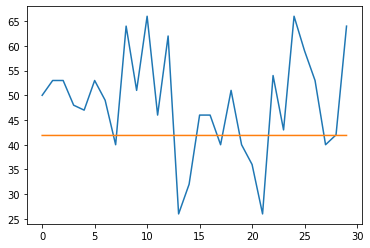

In [33]:
plt.plot(y)
plt.plot(y_pred)

In [34]:
X.shape

(30, 31, 2)

In [37]:
np.expand_dims(X[29], 0).shape

(1, 31, 2)

In [41]:
X[1]

array([[35.        , 39.        ],
       [41.        , 37.66666667],
       [28.        , 34.66666667],
       [49.        , 39.33333333],
       [52.        , 43.        ],
       [39.        , 46.66666667],
       [45.        , 45.33333333],
       [33.        , 39.        ],
       [36.        , 38.        ],
       [40.        , 36.33333333],
       [57.        , 44.33333333],
       [40.        , 45.66666667],
       [52.        , 49.66666667],
       [45.        , 45.66666667],
       [43.        , 46.66666667],
       [36.        , 41.33333333],
       [37.        , 38.66666667],
       [46.        , 39.66666667],
       [39.        , 40.66666667],
       [35.        , 40.        ],
       [40.        , 38.        ],
       [34.        , 36.33333333],
       [37.        , 37.        ],
       [36.        , 35.66666667],
       [46.        , 39.66666667],
       [51.        , 44.33333333],
       [53.        , 50.        ],
       [67.        , 57.        ],
       [54.        ,

In [42]:
X[2]

array([[41.        , 37.66666667],
       [28.        , 34.66666667],
       [49.        , 39.33333333],
       [52.        , 43.        ],
       [39.        , 46.66666667],
       [45.        , 45.33333333],
       [33.        , 39.        ],
       [36.        , 38.        ],
       [40.        , 36.33333333],
       [57.        , 44.33333333],
       [40.        , 45.66666667],
       [52.        , 49.66666667],
       [45.        , 45.66666667],
       [43.        , 46.66666667],
       [36.        , 41.33333333],
       [37.        , 38.66666667],
       [46.        , 39.66666667],
       [39.        , 40.66666667],
       [35.        , 40.        ],
       [40.        , 38.        ],
       [34.        , 36.33333333],
       [37.        , 37.        ],
       [36.        , 35.66666667],
       [46.        , 39.66666667],
       [51.        , 44.33333333],
       [53.        , 50.        ],
       [67.        , 57.        ],
       [54.        , 58.        ],
       [41.        ,

In [40]:
model.predict(np.expand_dims(X[1], 0))

array([[41.876976]], dtype=float32)

# Prediction chart

In [25]:
    """Create dataframe necessary to show a time series chart (total of reported stolen
    bikes in the last 31 days plus prediction for day 32)"""
    # read in data for the last 31 days and date of prediction
    X_input, pred_date = get_pred_array()

    # we only need the "total" column of X_input
    X_input = X_input[0][:,0]
    X_input = pd.Series(X_input)

    # get the predicted value for day 32 and the corresponding date
    pred_df = predict_next_day()

    # create empty dataframe starting 31 days before prediction date to prediction date
    pred_date = pred_df["date_reported"][0]
    chart_df = pd.DataFrame({'date':pd.date_range(start = pred_date - datetime.timedelta(days=31), end = pred_df["date_reported"][0])})

    # concatenate the values from X_input to the empty dataframe
    chart_df = pd.concat([chart_df, X_input], axis = 1)
    chart_df.rename(columns={0:"total"}, inplace=True)

    # add the predicted value as the last value
    chart_df.iloc[-1, 1] = pred_df["total"][0]
    
    chart_df["date"] = pd.to_datetime(chart_df["date"])

    fig = px.line(chart_df, x="date", y="total",
             labels = {"date": "date", 
                      "total": "Number of reported stolen bikes"})
    fig.add_scattergl(x=chart_df["date"].where(chart_df["date"] >=chart_df.iloc[-2,0]), y=chart_df["total"], line={"color": "red"},
                      showlegend=False)

    fig.update_layout({
    "plot_bgcolor": "rgba(0, 0, 0, 0)",
    "paper_bgcolor": "rgba(0, 0, 0, 0)",
    })
    
    return fig
    